In [78]:
# load the zebrafish functional couplings from here: https://funcoup.org/downloads/
# citations here (most recent is ok): https://funcoup.org/help/#Citation
# also check work done here for support: https://www.nature.com/articles/ncomms5071

import pandas as pd

funcoup_all = pd.read_csv("FC5.0_D.rerio_full", sep = "\t")

# filter functional couplings with probability functional coupling (pfc) >= 90%

funcoup_90 = funcoup_all[(funcoup_all["#0:PFC"] >= 0.9)]

# keep only the gene columns

funcoup_90_genes = df_filter.iloc[:, 2:4]

funcoup_90_genes.head(2)

,2:Gene1,3:Gene2
334,ENSDARG00000058710,ENSDARG00000039302
348,ENSDARG00000058710,ENSDARG00000039616


In [79]:
funcoup_90_genes.shape

(507700, 2)

In [80]:
# retrieve from BioMart the mappings between Gene stable ID <-> Gene name
biomart_mappings = pd.read_csv("mart_export.txt", sep = "\t")

# load the 98 candidate genes by Gene name
candidate_genes = ["hsd17b7", "serbp1a", "il12rb2", "LOC110438375", "LOC103909477", "cyp2p10", "cyp2p7", "cyp2n13", "cyp2p6", "hook1", 
                   "si:dkey-183n20.15", "pfas", "ipo13b", "muc5.1", "LOC562098", "mmachc", "lrrc4ca", "abhd2b", "rlbp1b", "isg20", 
                   "pdia3", "ckmt1", "ticrr", "si:ch1073-281m9.1", "alkbh3", "hsd17b12a", "LOC559196", "CBX1", "nfe2l1b", "D5F01_LYC18948", 
                   "copz2", "prr15la", "LOC110437935", "hipk3b", "imp3", "slc35a3a", "fam78ba", "cmpk", "bcl6ab", "zmym4.2", 
                   "cldn1", "cpn2", "fkbp1b", "her6", "atp13a3", "ncl", "gk5", "atp1b3a", "grk7a", "fbxo36b", 
                   "agfg1b", "si:dkeyp-13a3.3", "mffa", "stk25b", "vps11", "hyou1", "si:ch73-261i21.5", "hist2h2l", "h2ax1", "hspa8b",
                   "LOC110438375", "hspa8b", "jhy", "bsx", "lim2.1", "smarcc1a", "si:ch211-215k15.4", "dpy19l1l", "map7b", "hbs1l",
                   "armc1l", "mtfr2", "slc39a9", "pde7a", "myb", "aldh8a1", "txnrd2.2", "gnb1l", "tbx1", "si:ch211-244o22.2",
                   "kat6a", "ap3m2", "tet3", "bicdl1", "rab35a", "gcn1", "vamp5", "vamp8", "ncaph", "creb1b",
                   "mettl21a", "ccnyl1", "etnk1", "pyroxd1", "iapp", "slco1e1", "slco1d1", "itgbl1"]  # is "pign" one of the significant genes ?

# filter biomart mappings to contain only the candidate genes - 95 mapped genes
biomart_mappings_candidate_genes = biomart_mappings[biomart_mappings["Gene name"].isin(candidate_genes)]

# use the ensembl identifiers as a list
biomart_mappings_candidate_genes_ensembl = list(biomart_mappings_candidate_genes["Gene stable ID"])

In [81]:
# filter the >0.9 interactions to involve only the candidate genes - 7357 interactions

funcoup_90_candidate_genes = funcoup_90_genes[funcoup_90_genes['2:Gene1'].isin(biomart_mappings_candidate_genes_ensembl) 
                                            | funcoup_90_genes['3:Gene2'].isin(biomart_mappings_candidate_genes_ensembl)]


In [82]:
# make a list of all the intermediate genes

intermediate_genes = []

for line in range(len(funcoup_90_candidate_genes)):
    if line % 500 == 0:
        print(line, end = " ")
    if funcoup_90_candidate_genes.iloc[line, 0] not in biomart_mappings_candidate_genes_ensembl:
        intermediate_genes.append(funcoup_90_candidate_genes.iloc[line, 0])
    if funcoup_90_candidate_genes.iloc[line, 1] not in biomart_mappings_candidate_genes_ensembl:
        intermediate_genes.append(funcoup_90_candidate_genes.iloc[line, 1])

# count the number of occurences of intermediate genes

intermediate_gene_counts = pd.Series(intermediate_genes).value_counts()
max_threshold = intermediate_gene_counts.max()

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 

In [142]:
# for every level of occurence of intermediate genes (for example 14, 13, 12 ... occurences)
# caclulate the (a) number of intermediate genes, and (b) number of candidate genes, and
# estimate the enrichment level of candidate genes vs. total genes (intermediate & candidate)

p_values = []
threshold_ = []

for threshold in range(max_threshold):
    
    intermediate_genes_to_keep = intermediate_gene_counts[intermediate_gene_counts >= threshold+1].index.tolist()

    funcoup_90_intermediate_genes_to_keep = funcoup_90_genes[funcoup_90_genes['2:Gene1'].isin(intermediate_genes_to_keep) 
                                                           | funcoup_90_genes['3:Gene2'].isin(intermediate_genes_to_keep)]

    candidate_genes_subnetwork = []

    for line in range(len(funcoup_90_intermediate_genes_to_keep)):
        if funcoup_90_intermediate_genes_to_keep.iloc[line, 0] in biomart_mappings_candidate_genes_ensembl:
            candidate_genes_subnetwork.append(funcoup_90_intermediate_genes_to_keep.iloc[line, 0])
        if funcoup_90_intermediate_genes_to_keep.iloc[line, 1] in biomart_mappings_candidate_genes_ensembl:
            candidate_genes_subnetwork.append(funcoup_90_intermediate_genes_to_keep.iloc[line, 1])

    from scipy.stats import fisher_exact

    # Create a 2x2 contingency table
    cand_genes = len(set(candidate_genes_subnetwork))
    tot_genes = len(set(intermediate_genes_to_keep)) + cand_genes
    cand_genes_ref = len(set(biomart_mappings_candidate_genes_ensembl))
    tot_genes_ref = len(set(intermediate_genes)) + cand_genes_ref

    contingency_table = [[cand_genes, tot_genes],
                         [cand_genes_ref, tot_genes_ref]]

    # Perform Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)

    
    print(f"Threshold: {threshold+1}; Interactions: {len(funcoup_90_intermediate_genes_to_keep)}; Cand_Genes: {cand_genes}; Int_Genes: {len(set(intermediate_genes_to_keep))}; P-val: {p_value}")
#     print("Odds ratio:", odds_ratio)

    # store p-values as a numpy array
    p_values.append(p_value)
    threshold_.append(threshold)
p_values = np.array(p_values)
threshold_ = np.array(threshold_)

Threshold: 1; Interactions: 486393; Cand_Genes: 44; Int_Genes: 2443; P-val: 3.176241740665348e-05
Threshold: 2; Interactions: 448624; Cand_Genes: 43; Int_Genes: 1353; P-val: 0.3197488012434256
Threshold: 3; Interactions: 411317; Cand_Genes: 38; Int_Genes: 930; P-val: 0.8434346913689686
Threshold: 4; Interactions: 369450; Cand_Genes: 35; Int_Genes: 696; P-val: 0.23868182440852387
Threshold: 5; Interactions: 325078; Cand_Genes: 35; Int_Genes: 519; P-val: 0.014369992381318548
Threshold: 6; Interactions: 283073; Cand_Genes: 35; Int_Genes: 385; P-val: 0.000203588832836429
Threshold: 7; Interactions: 252448; Cand_Genes: 33; Int_Genes: 317; P-val: 3.44881431785512e-05
Threshold: 8; Interactions: 204574; Cand_Genes: 32; Int_Genes: 220; P-val: 1.8418280196686592e-07
Threshold: 9; Interactions: 172260; Cand_Genes: 32; Int_Genes: 170; P-val: 2.189409516959961e-09
Threshold: 10; Interactions: 140682; Cand_Genes: 32; Int_Genes: 131; P-val: 2.244011646489482e-11
Threshold: 11; Interactions: 91330; C

In [162]:
# ==========
# SIMULATION 
# ==========

# Step#1: I need to draw a random selection of 95 choices from the "funcoup_90_genes"

import numpy as np

SIMS = 1000

p_values_sim = []
threshold_sim = []

enumerate_ = 0

while enumerate_ < SIMS:
    
    print(enumerate_, end = " ")

    random_elements_col1 = funcoup_90_genes['2:Gene1'].unique()
    random_elements_col2 = funcoup_90_genes['3:Gene2'].unique()

    random_elements = list(set(random_elements_col1).union(set(random_elements_col2)))

    random_sample = np.random.choice(random_elements, 95, replace=False)

    funcoup_90_random_genes = funcoup_90_genes[funcoup_90_genes['2:Gene1'].isin(random_sample) 
                                             | funcoup_90_genes['3:Gene2'].isin(random_sample)]

    # make a list of all the intermediate genes

    intermediate_genes_random = []

    for line in range(len(funcoup_90_random_genes)):
#         if line % 500 == 0:
#             print(line, end = " ")
        if funcoup_90_random_genes.iloc[line, 0] not in random_sample:
            intermediate_genes_random.append(funcoup_90_random_genes.iloc[line, 0])
        if funcoup_90_random_genes.iloc[line, 1] not in random_sample:
            intermediate_genes_random.append(funcoup_90_random_genes.iloc[line, 1])

    # count the number of occurences of intermediate genes

    intermediate_random_gene_counts = pd.Series(intermediate_genes_random).value_counts()
    max_threshold_permutation = intermediate_random_gene_counts.max()

    # for every level of occurence of intermediate genes (for example 14, 13, 12 ... occurences)
    # caclulate the (a) number of intermediate genes, and (b) number of candidate genes, and
    # estimate the enrichment level of candidate genes vs. total genes (intermediate & candidate)



    for threshold in range(max_threshold_permutation):

        intermediate_random_genes_to_keep = intermediate_random_gene_counts[intermediate_random_gene_counts >= threshold+1].index.tolist()

        funcoup_90_intermediate_random_genes_to_keep = funcoup_90_random_genes[funcoup_90_random_genes['2:Gene1'].isin(intermediate_random_genes_to_keep) 
                                                                      | funcoup_90_random_genes['3:Gene2'].isin(intermediate_random_genes_to_keep)]

        candidate_random_genes_subnetwork = []

        for line in range(len(funcoup_90_intermediate_random_genes_to_keep)):
            if funcoup_90_intermediate_random_genes_to_keep.iloc[line, 0] in biomart_mappings_candidate_genes_ensembl:
                candidate_random_genes_subnetwork.append(funcoup_90_intermediate_random_genes_to_keep.iloc[line, 0])
            if funcoup_90_intermediate_random_genes_to_keep.iloc[line, 1] in biomart_mappings_candidate_genes_ensembl:
                candidate_random_genes_subnetwork.append(funcoup_90_intermediate_random_genes_to_keep.iloc[line, 1])

        from scipy.stats import fisher_exact

        # Create a 2x2 contingency table
        cand_random_genes = len(set(candidate_random_genes_subnetwork))
        tot_random_genes = len(set(intermediate_random_genes_to_keep)) + cand_random_genes
        cand_genes_ref = len(set(biomart_mappings_candidate_genes_ensembl))
        tot_genes_ref = len(set(intermediate_genes)) + cand_genes_ref

        contingency_table_perm = [[cand_random_genes, tot_random_genes],
                                 [cand_genes_ref, tot_genes_ref]]

#       Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table_perm)


#         print(f"Threshold: {threshold+1}; Interactions: {len(funcoup_90_intermediate_random_genes_to_keep)}; Cand_Genes: {cand_random_genes}; Int_Genes: {len(set(intermediate_random_genes_to_keep))}; P-val: {p_value}")
#         print("Odds ratio:", odds_ratio)

        p_values_sim.append(p_value)
        threshold_sim.append(threshold)
    p_values_sim.append(np.nan)
    threshold_sim.append(np.nan)
    enumerate_ += 1
        
p_values_sim = np.array(p_values_sim)
threshold_sim = np.array(threshold_sim)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

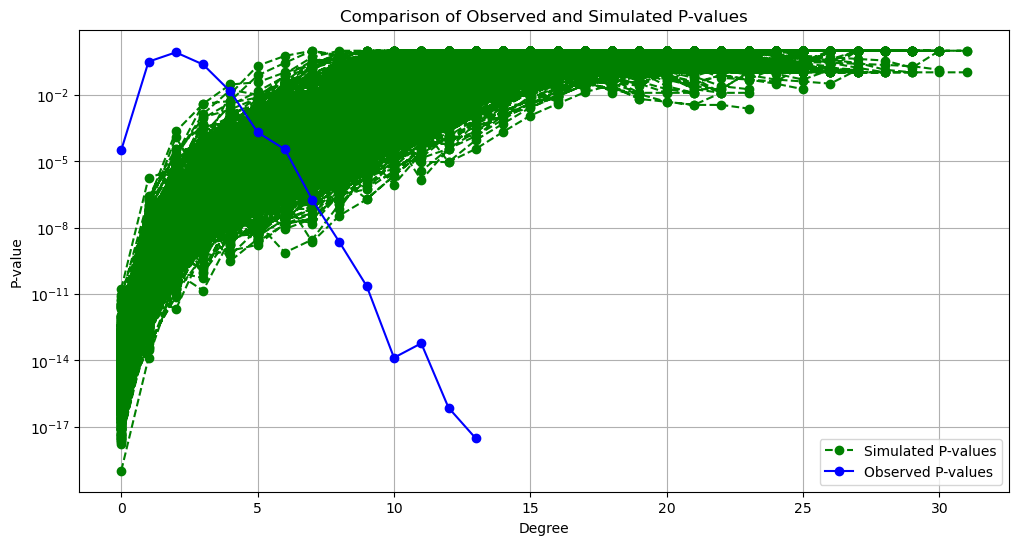

In [167]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot simulated p-values
plt.plot(threshold_sim, p_values_sim, label='Simulated P-values', marker='o', linestyle='--', color='green')

# Plot the given p-values
plt.plot(threshold_, p_values, label='Observed P-values', marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Degree')
plt.ylabel('P-value')
plt.title('Comparison of Observed and Simulated P-values')
plt.yscale('log')  # Log scale for better visualization of p-values
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


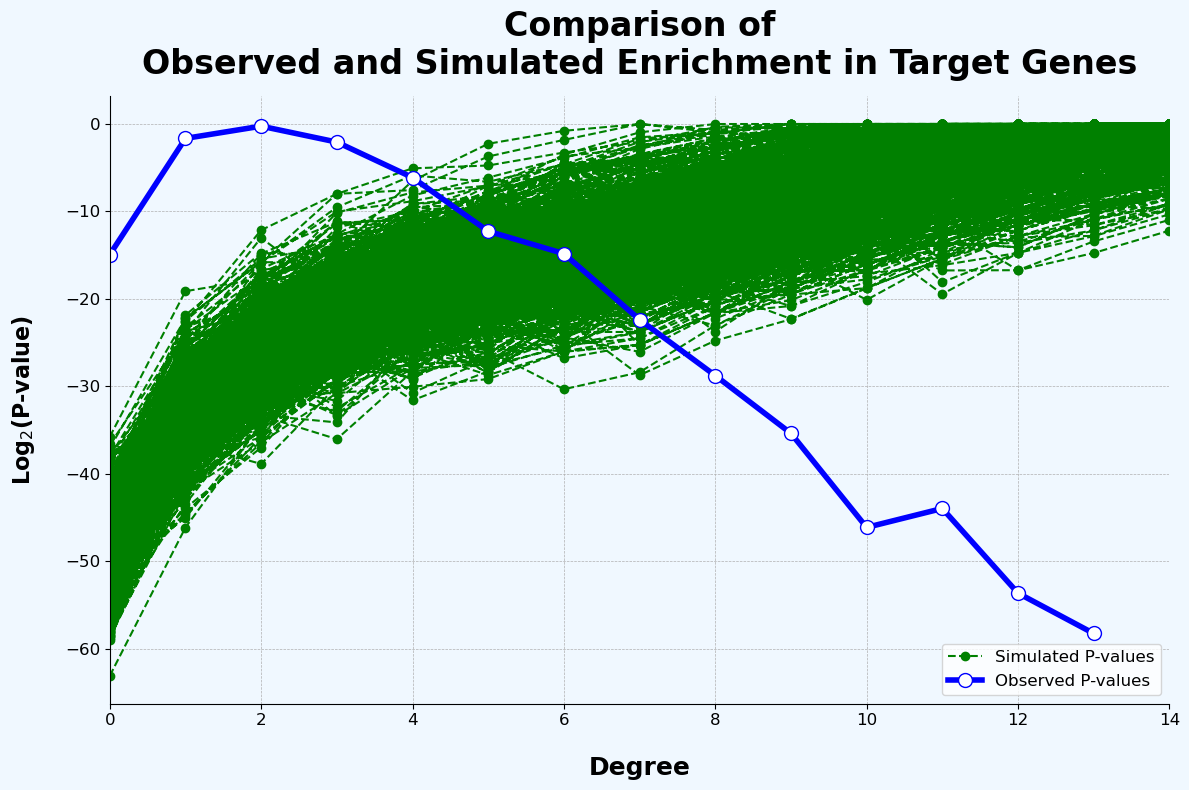

In [208]:
# Create the plot
fig, ax = plt.figure(figsize=(12, 8), facecolor='aliceblue'), plt.gca()
ax.set_facecolor('aliceblue')

# Plot simulated p-values
plt.plot(threshold_sim, np.log2(p_values_sim), label='Simulated P-values', marker='o', linestyle='--', color='green')

# Plot the given p-values
plt.plot(threshold_, np.log2(p_values), label='Observed P-values', marker='o', linestyle='-', color='blue', 
         linewidth=4, markersize=10, markerfacecolor='white')

# Add labels and title with increased font size
plt.xlabel('Degree', fontsize=18, fontweight='bold', labelpad=20)
plt.ylabel(r'Log$_2$(P-value)', fontsize=16, fontweight='bold', labelpad=20)
plt.title('Comparison of\nObserved and Simulated Enrichment in Target Genes', 
          fontsize=24, fontweight='bold', pad=16)
# plt.yscale('log')  # Log scale for better visualization of p-values

# Set x-axis limit to show only up to degree 14
plt.xlim(0, 14)

# Customize the legend
plt.legend(fontsize=12, title_fontsize='13')

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right borders
sns.despine()

# Save the plot
plt.savefig('Simulations_Interactions.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

